In [134]:
import torch
import pandas as pd
import numpy as np
import cv2
from IPython.display import display
from torchvision import utils
from PIL import Image, ImageDraw

In [3]:
df = pd.read_csv(r'C:\Users\Kusha\OneDrive\Desktop\Faces\data\faces.csv')
df.head()

image_name  width  height   x0   y0    x1   y1
0  00001722.jpg   1333    2000  490  320   687  664
1  00001044.jpg   2000    1333  791  119  1200  436
2  00001050.jpg    667    1000  304  155   407  331
3  00001736.jpg    626     417  147   14   519  303
4  00003121.jpg    626     418  462   60   599  166

In [4]:
len(df)

3350

In [5]:
len(df['image_name'].unique())

2204

In [6]:
df.isnull().sum()

image_name    0
width         0
height        0
x0            0
y0            0
x1            0
y1            0
dtype: int64

In [7]:
df.duplicated().sum()

0

In [17]:
annos_dict = {}

for index, row in df.iterrows():
    image_name = row['image_name']
    if image_name in annos_dict:
        annos_dict[image_name].append([row['x0'], row['y0'], row['x1'], row['y1']])
    else:
        coordinates = [row['x0'], row['y0'], row['x1'], row['y1']]
        
        annos_dict[image_name] = [coordinates]

In [150]:
face_counts = {}
for values in annos_dict.values():
    count = len(values)
    face_counts[count] = face_counts.get(count, 0) + 1

for count, num_images in sorted(face_counts.items()):
    print(f"Images with {count} face(s): {num_images}")

Images with 1 face(s): 1713
Images with 2 face(s): 218
Images with 3 face(s): 111
Images with 4 face(s): 55
Images with 5 face(s): 55
Images with 6 face(s): 24
Images with 7 face(s): 12
Images with 8 face(s): 7
Images with 9 face(s): 5
Images with 10 face(s): 1
Images with 11 face(s): 2
Images with 12 face(s): 1


In [19]:
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torchvision import transforms
import os

In [20]:
image_dir = "C:/Users/Kusha/OneDrive/Desktop/Faces/data/images"

In [152]:
class Data(Dataset):
    def __init__(self, annos_dict, image_dir, transform=None, max_faces=12):
        super().__init__()
        self.annos_dict = annos_dict
        self.image_dir = image_dir
        self.transform = transform
        self.max_faces = max_faces
        self.image_names = list(self.annos_dict.keys())  

    def __len__(self):  
        return len(self.image_names)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image_name = self.image_names[idx]  
        image_path = os.path.join(self.image_dir, image_name)
        img_arr = cv2.imread(image_path)
        annos = self.annos_dict[image_name]
        
        if len(annos) < self.max_faces:
            padding = [[0, 0, 0, 0]] * (self.max_faces - len(annos))
            annos = annos + padding
        annos = annos[:self.max_faces]
        
        sample = {'image': img_arr, 'annotations': annos}
        if self.transform:
            sample = self.transform(sample)
        
        return sample

In [153]:
Img = Data(annos_dict , image_dir)
sample = Img[17]

In [154]:
sample['annotations']

[[684, 251, 987, 486],
 [34, 195, 344, 435],
 [375, 279, 678, 509],
 [486, 239, 796, 474],
 [913, 215, 1097, 446],
 [0, 0, 0, 0],
 [0, 0, 0, 0],
 [0, 0, 0, 0],
 [0, 0, 0, 0],
 [0, 0, 0, 0],
 [0, 0, 0, 0],
 [0, 0, 0, 0]]

In [155]:
sample['annotations'][0]

[684, 251, 987, 486]

In [156]:
def img_an_plot(sample):
    img_with_annos = sample['image'].copy()
    annos = sample['annotations']
    for anno in annos[0:]:
        x0, y0, x1, y1 = anno
        cv2.rectangle(img_with_annos, (x0, y0), (x1, y1), (0, 0, 255), thickness=2)
    
    img_rgb = cv2.cvtColor(img_with_annos, cv2.COLOR_BGR2RGB)
    bbox_img = Image.fromarray(img_rgb)
    display(bbox_img)
   

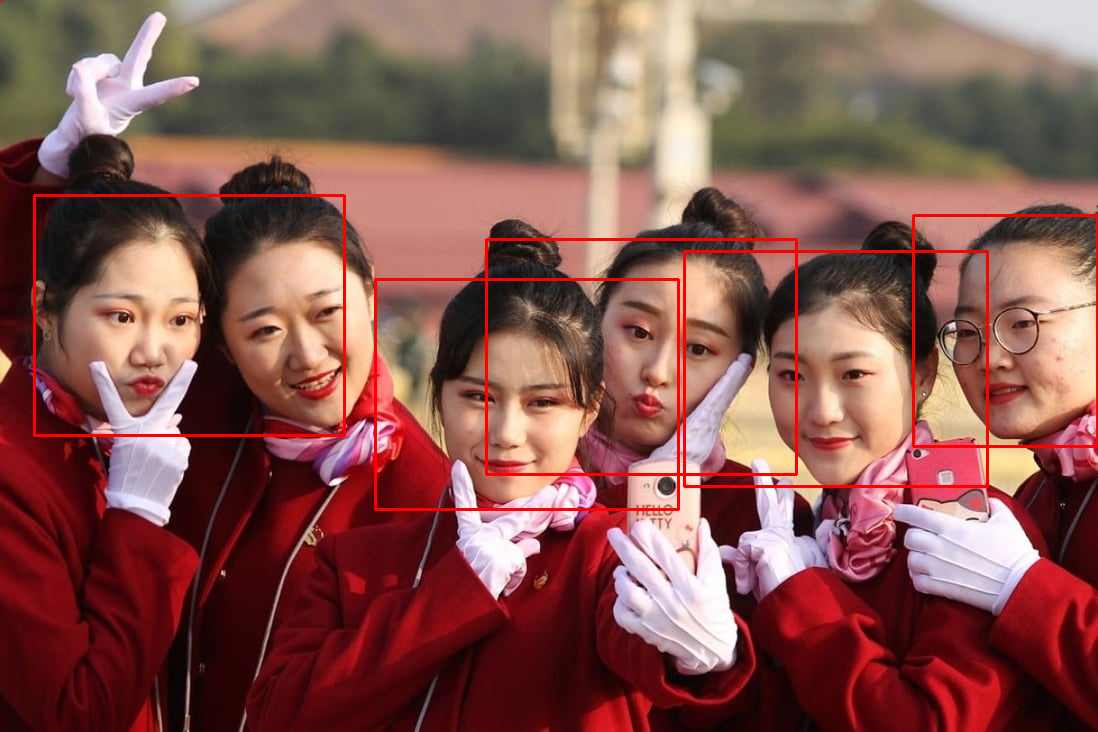

In [157]:
test = img_an_plot(sample)

In [158]:
class Rescale(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, annos = sample['image'], sample['annotations']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            new_h, new_w = self.output_size, self.output_size
        else:
            new_h, new_w = self.output_size
            
        new_h, new_w = int(new_h), int(new_w)
        img = Image.fromarray(image)
        imf = img.resize((new_w, new_h))  
        img_array = np.array(imf)

        new_annos = []
        for anno in annos:
            new_anno = [
                anno[0] * new_w / w,  # x0
                anno[1] * new_h / h,  # y0
                anno[2] * new_w / w,  # x1
                anno[3] * new_h / h   # y1
            ]
            new_annos.append(new_anno)
        return {'image': img_array, 'annotations': new_annos}

In [159]:
class  ToTensor(object):
    def __call__(self , sample):
        image , annos = sample['image'] , sample['annotations']

        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image) , 'annotations': torch.from_numpy(np.array(annos))}

In [185]:
class ToTensor(object):
    def __call__(self, sample):
        image, annos = sample['image'], sample['annotations']
        
        image = image.astype(np.float32) / 255.0
        image = image.transpose((2, 0, 1))
        
        return {
            'image': torch.from_numpy(image),
            'annotations': torch.from_numpy(np.array(annos, dtype=np.float32))
        }

In [186]:
class Normalize(object):
    def __init__(self, mean, std):
        self.mean = torch.tensor(mean).view(3, 1, 1)
        self.std = torch.tensor(std).view(3, 1, 1)

    def __call__(self, sample):
        image, annos = sample['image'], sample['annotations']
        
        image = (image - self.mean) / self.std
        
        return {'image': image, 'annotations': annos}

In [188]:
test1 = Rescale(256)


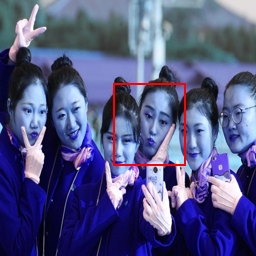

In [189]:
imga = Image.fromarray(test1(sample)['image'])
draw = ImageDraw.Draw(imga)
draw.rectangle(test1(sample)['annotations'][3], outline='red', width=2)
imga

In [187]:
Datasetgen = Data(annos_dict, image_dir, 
                  transform=transforms.Compose([
                      Rescale(256),
                      ToTensor(),
                      Normalize(
                          mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]
                      )
                  ]),
                  max_faces=12)

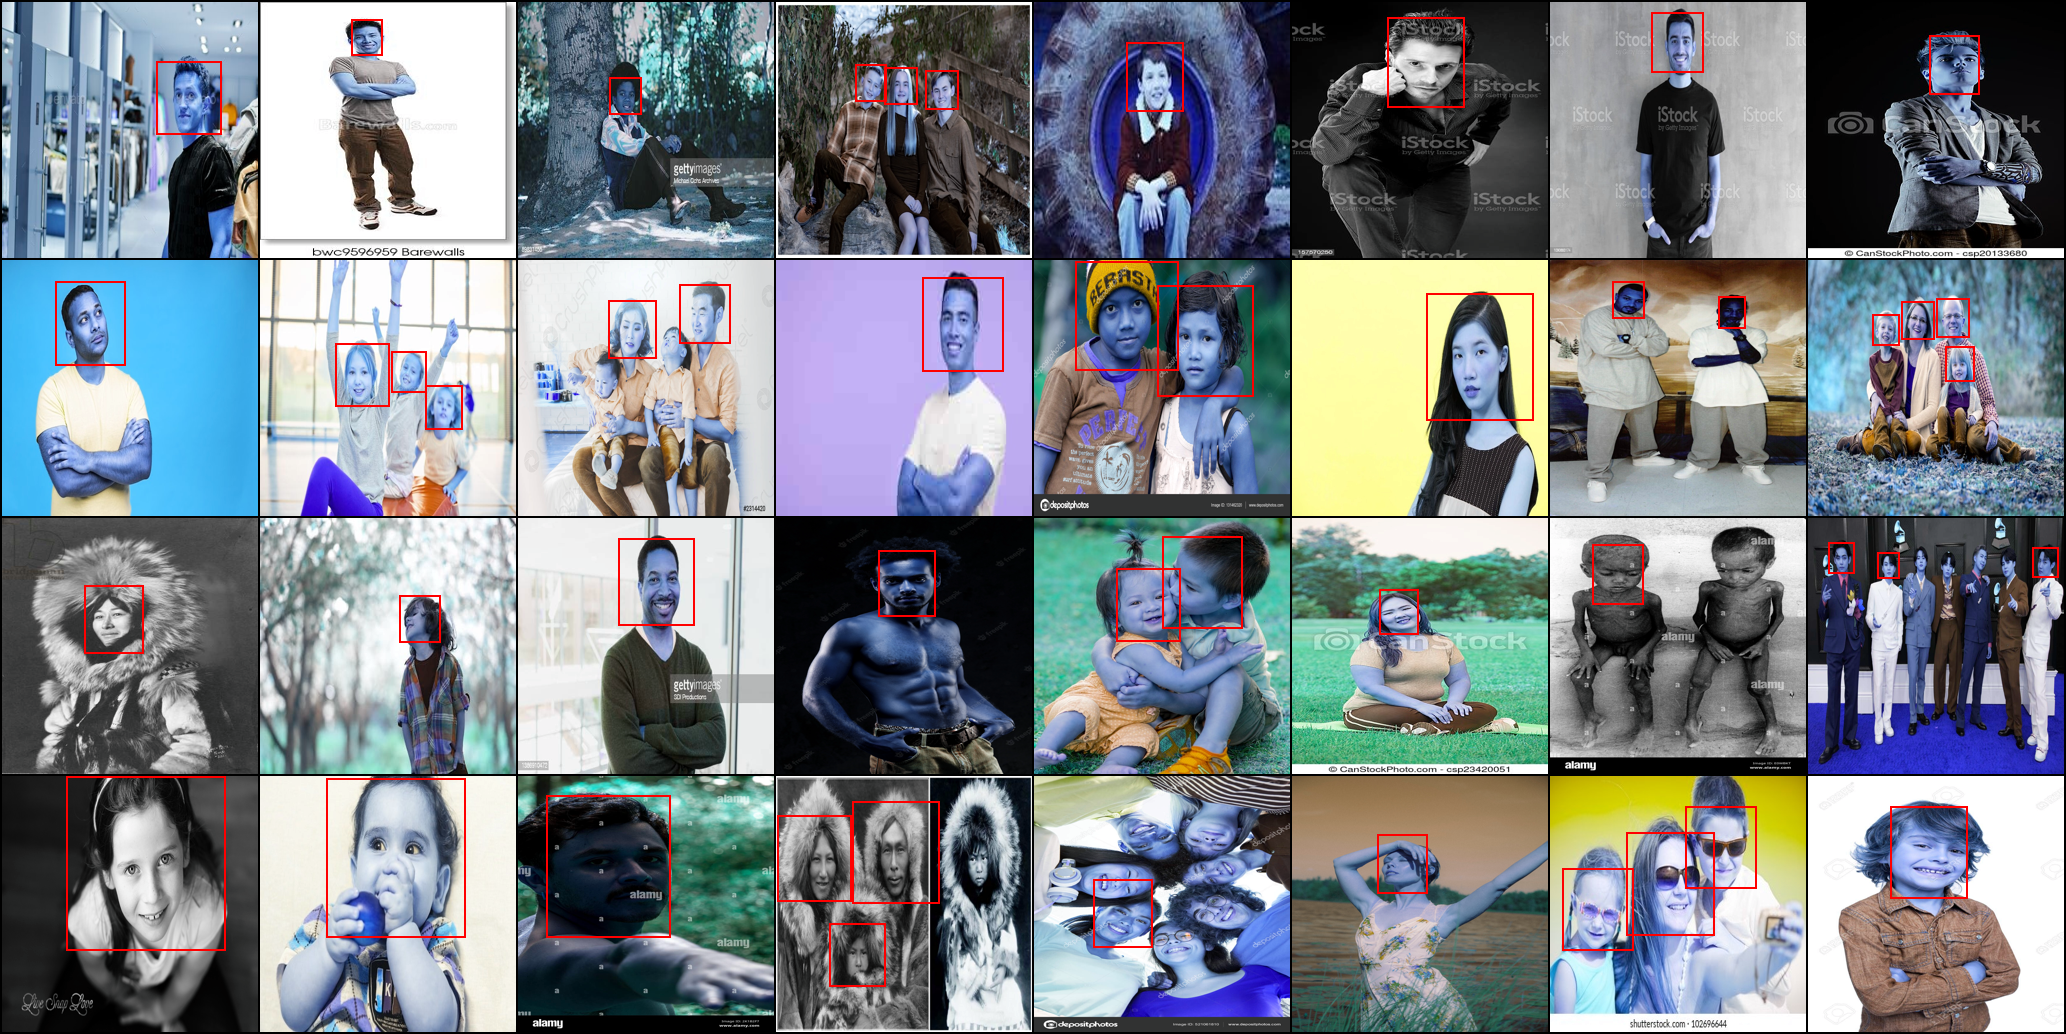

In [ ]:
dataloader = DataLoader(Datasetgen, batch_size=32,
                       shuffle=True, num_workers=0)

def show_batch_with_boxes(sample_batched):
    images_batch, boxes_batch = sample_batched['image'], sample_batched['annotations']
    batch_size = len(images_batch)
    
    images_with_boxes = []
    
    for idx in range(batch_size):
        img = images_batch[idx].clone()
        img = img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        img = img + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        
        img = img.numpy().transpose(1, 2, 0)
        img = (img * 255).clip(0, 255).astype(np.uint8)
        
        img = Image.fromarray(img)
        draw = ImageDraw.Draw(img)
        
        boxes = boxes_batch[idx]
        for box in boxes:
            x0, y0, x1, y1 = box.tolist()
            if x0 != 0 or y0 != 0 or x1 != 0 or y1 != 0:
                draw.rectangle([x0, y0, x1, y1], outline='red', width=2)
        
        img_tensor = transforms.ToTensor()(img)
        images_with_boxes.append(img_tensor)
    
    images_with_boxes = torch.stack(images_with_boxes)
    
    grid = utils.make_grid(images_with_boxes, nrow=8, padding=2)
    grid_img = transforms.ToPILImage()(grid)
    display(grid_img)

for i, batch in enumerate(dataloader):
    show_batch_with_boxes(batch)
    break 

In [177]:
class model(nn.Module):
    def __init__(self, num_boxes=12):
        super(model, self).__init__()
        self.num_boxes = num_boxes  
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )
        
        self.bbox_head = nn.Sequential(
            nn.AdaptiveAvgPool2d((4, 4)),
            nn.Flatten(),
            nn.Linear(512 * 4 * 4, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, num_boxes * 4)  
        )

    def forward(self, x):
        features = self.features(x)
        
        bbox_pred = self.bbox_head(features)
        bbox_pred = bbox_pred.view(-1, self.num_boxes, 4) 
        
        return bbox_pred

In [180]:
from tqdm import tqdm
import torchvision.models as models

In [191]:
class FaceDetectionModel(nn.Module):
    def __init__(self, num_boxes=12):
        super(FaceDetectionModel, self).__init__()
        self.num_boxes = num_boxes
        
        # Load pre-trained ResNet50 
        self.backbone = models.resnet50(pretrained=True)
        self.backbone = nn.Sequential(*list(self.backbone.children())[:-2])
        

        for param in list(self.backbone.parameters())[:-6]:  # Keep last 2 blocks trainable
            param.requires_grad = False
        
        self.bbox_head = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(2048, 1024),  
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, num_boxes * 4)  
        )

    def forward(self, x):
        features = self.backbone(x)
        
        bbox_pred = self.bbox_head(features)
        bbox_pred = bbox_pred.view(-1, self.num_boxes, 4)
        
        return bbox_pred

In [192]:
model = FaceDetectionModel(num_boxes=12)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

c:\anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\Kusha/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:21<00:00, 4.77MB/s]


In [193]:
criterion = nn.SmoothL1Loss()  
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50
best_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for batch_idx, batch in enumerate(tqdm(dataloader, desc=f'Epoch {epoch+1}/{num_epochs}')):
        images = batch['image'].to(device)
        targets = batch['annotations'].to(device)
        
        optimizer.zero_grad()

        outputs = model(images)
    
        loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    epoch_loss = running_loss / len(dataloader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')
    
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        torch.save(model.state_dict(), 'best_face_detection_model.pth')

print('Training finished!')

Epoch 1/50: 100%|██████████| 69/69 [04:48<00:00,  4.18s/it]


Epoch [1/50], Loss: 9.4152


Epoch 2/50: 100%|██████████| 69/69 [03:35<00:00,  3.13s/it]


Epoch [2/50], Loss: 7.0800


Epoch 3/50: 100%|██████████| 69/69 [03:37<00:00,  3.15s/it]


Epoch [3/50], Loss: 6.1903


Epoch 4/50: 100%|██████████| 69/69 [03:40<00:00,  3.20s/it]


Epoch [4/50], Loss: 5.7549


Epoch 5/50: 100%|██████████| 69/69 [03:34<00:00,  3.11s/it]


Epoch [5/50], Loss: 5.4534


Epoch 6/50: 100%|██████████| 69/69 [03:48<00:00,  3.31s/it]


Epoch [6/50], Loss: 5.2120


Epoch 7/50: 100%|██████████| 69/69 [03:35<00:00,  3.12s/it]


Epoch [7/50], Loss: 4.9829


Epoch 8/50: 100%|██████████| 69/69 [03:22<00:00,  2.93s/it]


Epoch [8/50], Loss: 4.8747


Epoch 9/50: 100%|██████████| 69/69 [03:10<00:00,  2.76s/it]


Epoch [9/50], Loss: 4.7909


Epoch 10/50: 100%|██████████| 69/69 [03:07<00:00,  2.71s/it]


Epoch [10/50], Loss: 4.6249


Epoch 11/50: 100%|██████████| 69/69 [03:30<00:00,  3.04s/it]


Epoch [11/50], Loss: 4.4853


Epoch 12/50: 100%|██████████| 69/69 [03:56<00:00,  3.43s/it]


Epoch [12/50], Loss: 4.5415


Epoch 13/50: 100%|██████████| 69/69 [03:06<00:00,  2.70s/it]


Epoch [13/50], Loss: 4.4775


Epoch 14/50: 100%|██████████| 69/69 [02:55<00:00,  2.55s/it]


Epoch [14/50], Loss: 4.3683


Epoch 15/50: 100%|██████████| 69/69 [03:08<00:00,  2.73s/it]


Epoch [15/50], Loss: 4.3001


Epoch 16/50: 100%|██████████| 69/69 [02:44<00:00,  2.39s/it]


Epoch [16/50], Loss: 4.2627


Epoch 17/50: 100%|██████████| 69/69 [02:49<00:00,  2.46s/it]


Epoch [17/50], Loss: 4.2475


Epoch 18/50: 100%|██████████| 69/69 [03:29<00:00,  3.03s/it]


Epoch [18/50], Loss: 4.1191


Epoch 19/50: 100%|██████████| 69/69 [03:30<00:00,  3.04s/it]


Epoch [19/50], Loss: 4.1026


Epoch 20/50: 100%|██████████| 69/69 [03:26<00:00,  2.99s/it]


Epoch [20/50], Loss: 3.9980


Epoch 21/50: 100%|██████████| 69/69 [03:22<00:00,  2.93s/it]


Epoch [21/50], Loss: 3.8974


Epoch 22/50: 100%|██████████| 69/69 [03:23<00:00,  2.95s/it]


Epoch [22/50], Loss: 3.9285


Epoch 23/50: 100%|██████████| 69/69 [03:23<00:00,  2.95s/it]


Epoch [23/50], Loss: 3.7988


Epoch 24/50: 100%|██████████| 69/69 [03:22<00:00,  2.93s/it]


Epoch [24/50], Loss: 3.6888


Epoch 25/50: 100%|██████████| 69/69 [03:35<00:00,  3.12s/it]


Epoch [25/50], Loss: 3.6968


Epoch 26/50: 100%|██████████| 69/69 [03:21<00:00,  2.92s/it]


Epoch [26/50], Loss: 3.6350


Epoch 27/50: 100%|██████████| 69/69 [03:33<00:00,  3.10s/it]


Epoch [27/50], Loss: 3.5519


Epoch 28/50: 100%|██████████| 69/69 [03:36<00:00,  3.14s/it]


Epoch [28/50], Loss: 3.5384


Epoch 29/50: 100%|██████████| 69/69 [03:37<00:00,  3.16s/it]


Epoch [29/50], Loss: 3.5283


Epoch 30/50: 100%|██████████| 69/69 [04:04<00:00,  3.55s/it]


Epoch [30/50], Loss: 3.4903


Epoch 31/50: 100%|██████████| 69/69 [02:54<00:00,  2.52s/it]


Epoch [31/50], Loss: 3.3995


Epoch 32/50: 100%|██████████| 69/69 [03:16<00:00,  2.84s/it]


Epoch [32/50], Loss: 3.4340


Epoch 33/50: 100%|██████████| 69/69 [02:42<00:00,  2.35s/it]


Epoch [33/50], Loss: 3.3728


Epoch 34/50: 100%|██████████| 69/69 [03:04<00:00,  2.67s/it]


Epoch [34/50], Loss: 3.3751


Epoch 35/50: 100%|██████████| 69/69 [02:51<00:00,  2.48s/it]


Epoch [35/50], Loss: 3.2813


Epoch 36/50: 100%|██████████| 69/69 [03:08<00:00,  2.73s/it]


Epoch [36/50], Loss: 3.2873


Epoch 37/50: 100%|██████████| 69/69 [02:54<00:00,  2.53s/it]


Epoch [37/50], Loss: 3.2138


Epoch 38/50: 100%|██████████| 69/69 [02:46<00:00,  2.41s/it]


Epoch [38/50], Loss: 3.1851


Epoch 39/50: 100%|██████████| 69/69 [03:09<00:00,  2.75s/it]


Epoch [39/50], Loss: 3.1743


Epoch 40/50: 100%|██████████| 69/69 [03:41<00:00,  3.22s/it]


Epoch [40/50], Loss: 3.1872


Epoch 41/50: 100%|██████████| 69/69 [03:27<00:00,  3.00s/it]


Epoch [41/50], Loss: 3.1636


Epoch 42/50: 100%|██████████| 69/69 [02:51<00:00,  2.48s/it]


Epoch [42/50], Loss: 3.1264


Epoch 43/50: 100%|██████████| 69/69 [02:55<00:00,  2.55s/it]


Epoch [43/50], Loss: 3.1535


Epoch 44/50: 100%|██████████| 69/69 [03:04<00:00,  2.68s/it]


Epoch [44/50], Loss: 3.0788


Epoch 45/50: 100%|██████████| 69/69 [02:50<00:00,  2.48s/it]


Epoch [45/50], Loss: 3.0972


Epoch 46/50: 100%|██████████| 69/69 [02:43<00:00,  2.37s/it]


Epoch [46/50], Loss: 3.1257


Epoch 47/50: 100%|██████████| 69/69 [02:48<00:00,  2.45s/it]


Epoch [47/50], Loss: 3.0646


Epoch 48/50: 100%|██████████| 69/69 [02:56<00:00,  2.55s/it]


Epoch [48/50], Loss: 3.0901


Epoch 49/50: 100%|██████████| 69/69 [03:30<00:00,  3.05s/it]


Epoch [49/50], Loss: 3.0612


Epoch 50/50: 100%|██████████| 69/69 [03:58<00:00,  3.45s/it]

Epoch [50/50], Loss: 3.0909
Training finished!


In [195]:
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': num_epochs,
    'best_loss': best_loss
}, 'face_detection_checkpoint.pth')


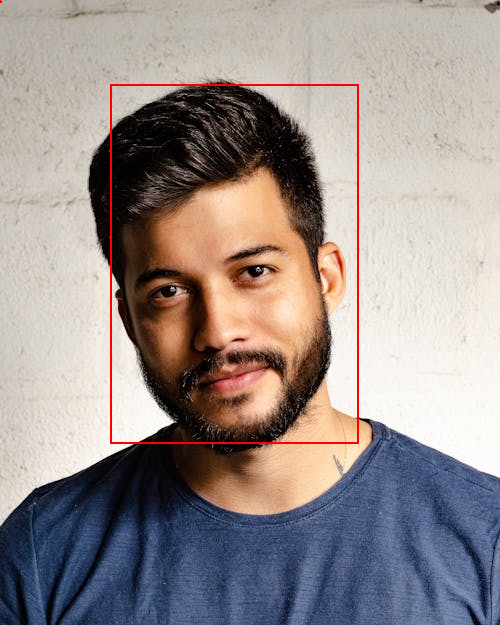

In [203]:
def load_and_prepare_image(image_path, size=256):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    orig_h, orig_w = img.shape[:2]
    
    img = Image.fromarray(img)
    img = img.resize((size, size))
    img = np.array(img)
    
    img = img.astype(np.float32) / 255.0
    img = img.transpose((2, 0, 1))
    img = torch.from_numpy(img)
    
    normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
    img = normalize(img)
    
    return img.unsqueeze(0), (orig_h, orig_w)  

def predict_and_plot(model, image_path):
    model.eval()
    
    img_tensor, (orig_h, orig_w) = load_and_prepare_image(image_path)
    img_tensor = img_tensor.to(device)
    
    with torch.no_grad():
        predictions = model(img_tensor)
        predictions = predictions.cpu().numpy()[0]  
    
    orig_img = cv2.imread(image_path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    
    scale_w = orig_w / 256
    scale_h = orig_h / 256
    
    img_with_boxes = Image.fromarray(orig_img)
    draw = ImageDraw.Draw(img_with_boxes)
    
    for box in predictions:
        x0, y0, x1, y1 = box
        x0, x1 = int(x0 * scale_w), int(x1 * scale_w)
        y0, y1 = int(y0 * scale_h), int(y1 * scale_h)
        
        if x0 != 0 or y0 != 0 or x1 != 0 or y1 != 0:
            draw.rectangle([x0, y0, x1, y1], outline='red', width=2)
    
    display(img_with_boxes)

model = FaceDetectionModel(num_boxes=12)
checkpoint = torch.load('face_detection_checkpoint.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)


image_path = r"C:\Users\Kusha\OneDrive\Desktop\Faces\test2.jpeg"  
predict_and_plot(model, image_path)